<a href="https://colab.research.google.com/github/dejunga/ML-Vehicle_Image_Classification/blob/main/Vehicle_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Define paths to the models stored on your Google Drive
tensorflow_model_path = '/content/drive/My Drive/models/tensorflow_vehicle_model.keras'  # Adjust path as necessary
fastai_model_path = '/content/drive/My Drive/models/fastai_vehicle_model.pkl'  # Adjust path as necessary
base_split_dir = "/content/drive/My Drive/vehicles_split"
main_dir = "/content/drive/My Drive/Vehicles"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

print(tf.version.VERSION)

# Define the categories you have for vehicle classification
categories = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles", "Planes", "Ships", "Trains"]

# Prepare image data generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Set the paths to train, validation, and test folders in Google Drive
train_generator = train_datagen.flow_from_directory(os.path.join(base_split_dir, "train"),
                                                    target_size=(150, 150), batch_size=32, class_mode='categorical')
val_generator = val_test_datagen.flow_from_directory(os.path.join(base_split_dir, "val"),
                                                     target_size=(150, 150), batch_size=32, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory(os.path.join(base_split_dir, "test"),
                                                      target_size=(150, 150), batch_size=32, class_mode='categorical')

2.15.0
Found 3911 images belonging to 7 classes.
Found 838 images belonging to 7 classes.
Found 838 images belonging to 7 classes.


In [54]:
!ls /content/drive/My\ Drive/models/

fastai_model_history.pkl  model_history.pkl
fastai_vehicle_model.pkl  tensorflow_vehicle_model.keras


In [55]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Rebuild the architecture exactly as it was during training
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes as per your original categories
])


In [56]:
# Load the saved TensorFlow model from Google Drive
print(tensorflow_model_path)
model = tf.keras.models.load_model(tensorflow_model_path)

# Check model summary to verify it was loaded correctly
model.summary()

# Evaluate on test data
#test_loss, test_acc = model.evaluate(test_generator)
test_loss, test_acc = model.evaluate(test_generator, steps=10)  # Adjust steps as needed

print(f"Test accuracy: {test_acc * 100:.2f}%")


/content/drive/My Drive/models/tensorflow_vehicle_model.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 18913095 (72.15 MB)
Trainable params: 4198407 (16.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_____________

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 249ms/step


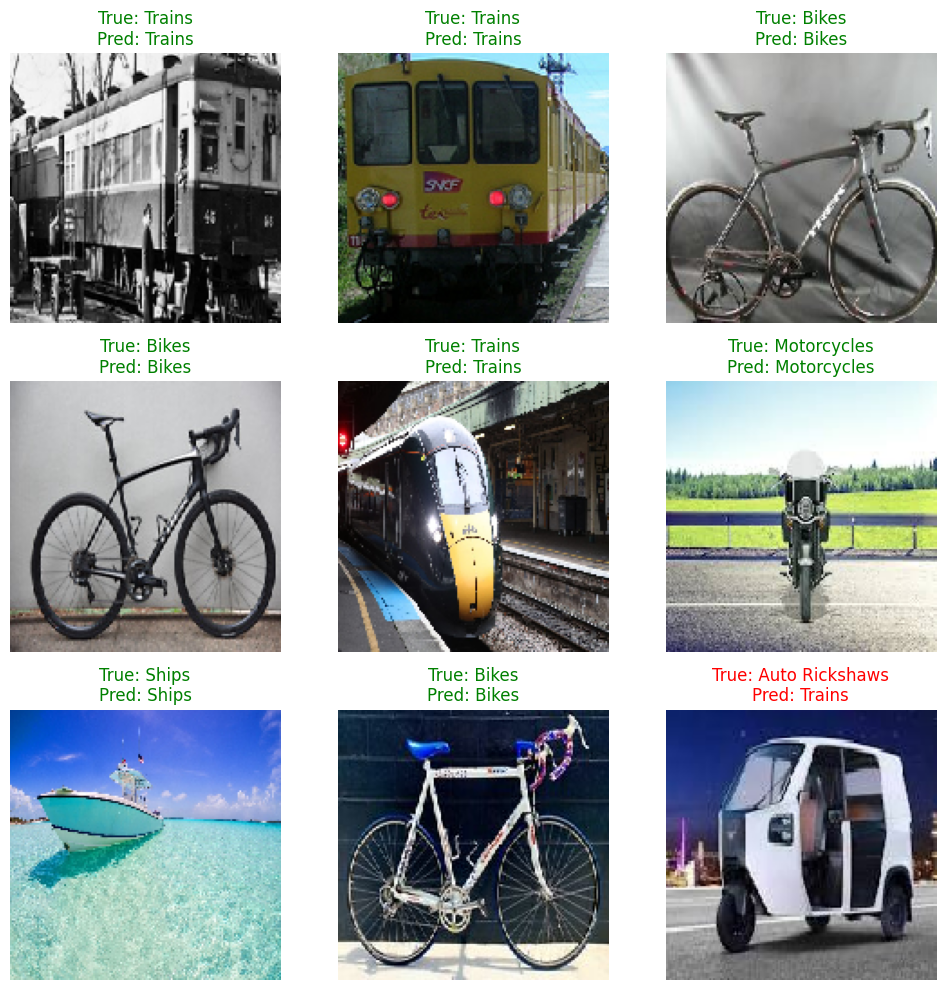

In [58]:
import matplotlib.pyplot as plt
import random

# Get a batch of test images and labels
test_images, test_labels = next(test_generator)
indices = random.sample(range(len(test_images)), 9)  # Pick 9 random images

# Predict on the selected test images
predictions = model.predict(test_images[indices])
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels[indices], axis=1)

# Plot predictions with true labels
plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx])
    plt.axis('off')

    true_label = categories[true_labels[i]]
    predicted_label = categories[predicted_labels[i]]
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()


27/27 [==============================] - 13s 442ms/step


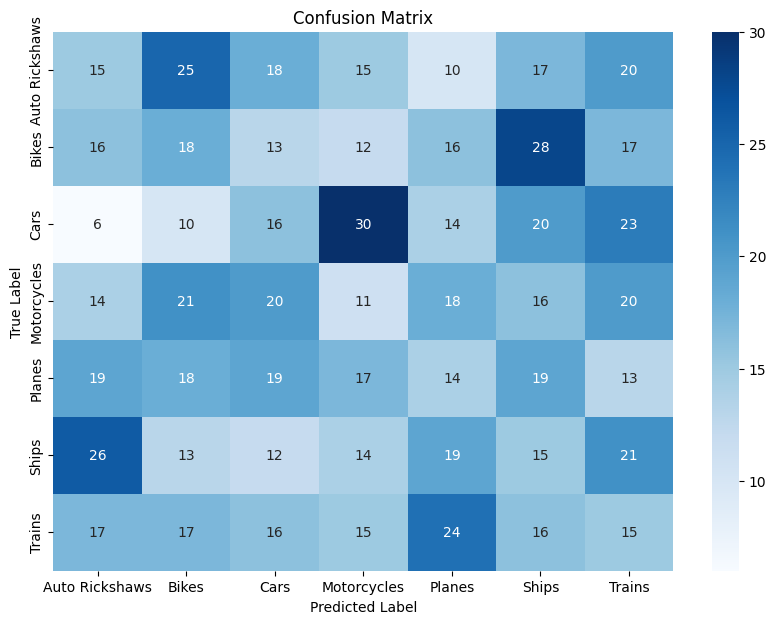

In [59]:
# Generate predictions on the test set
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [60]:
# Classification report (precision, recall, f1-score)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
                 precision    recall  f1-score   support

Auto Rickshaws       0.13      0.12      0.13       120
         Bikes       0.15      0.15      0.15       120
          Cars       0.14      0.13      0.14       119
   Motorcycles       0.10      0.09      0.09       120
        Planes       0.12      0.12      0.12       119
         Ships       0.11      0.12      0.12       120
        Trains       0.12      0.12      0.12       120

      accuracy                           0.12       838
     macro avg       0.12      0.12      0.12       838
  weighted avg       0.12      0.12      0.12       838



In [61]:
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


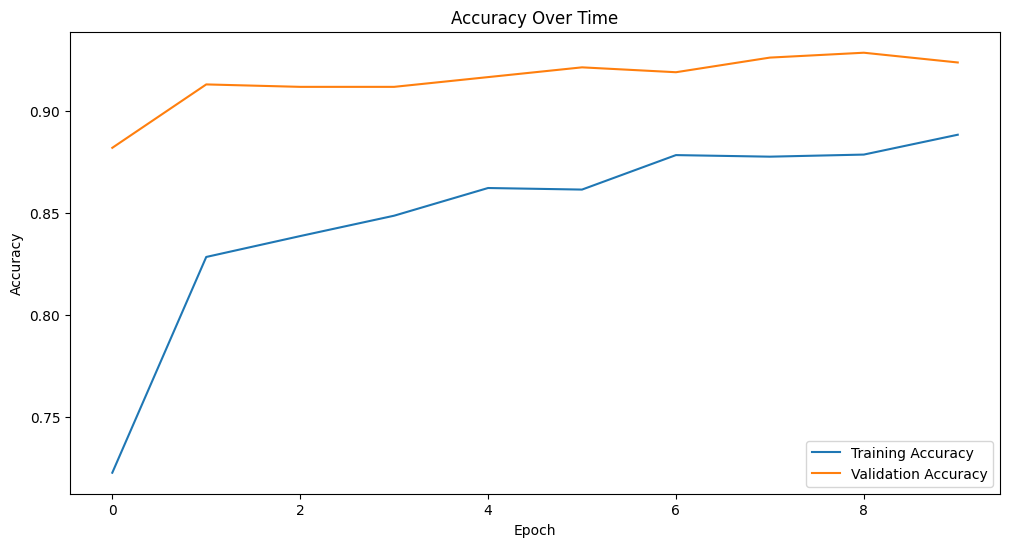

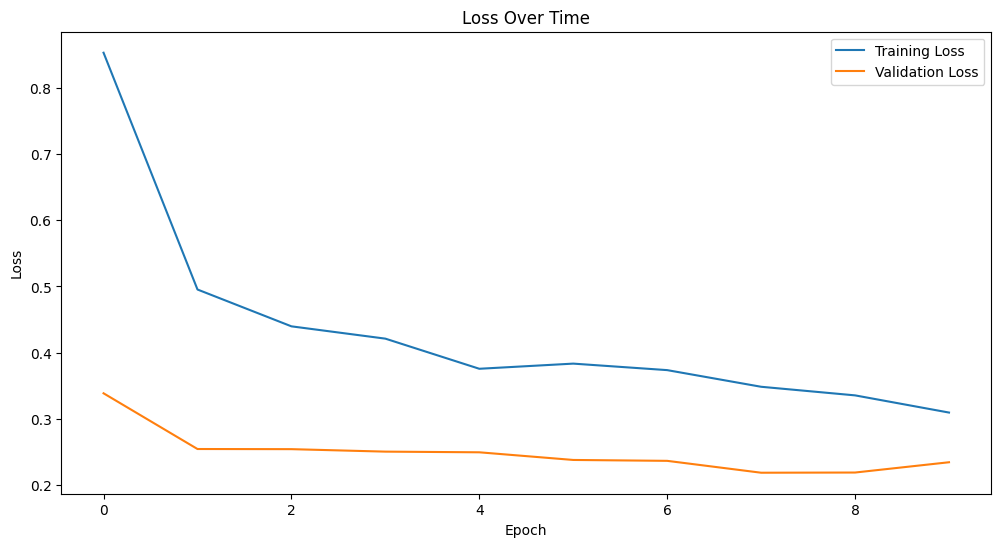

In [62]:
import pickle
import matplotlib.pyplot as plt

# Load the TensorFlow model history (for model_history.pkl)
history_path = '/content/drive/My Drive/models/model_history.pkl'
with open(history_path, 'rb') as file_pi:
    history = pickle.load(file_pi)

# Plot accuracy over epochs (TensorFlow)
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss over epochs (TensorFlow)
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
import time
import math

# Assuming `model` is your trained TensorFlow model
# Assuming `test_generator` is your data generator for test data

# Calculate the number of steps per epoch for the test data
test_steps_per_epoch = math.ceil(test_generator.samples / test_generator.batch_size)

# Start the timer
start_time = time.time()

# Make predictions on the test set
predictions = model.predict(test_generator, steps=test_steps_per_epoch)

# End the timer
end_time = time.time()

# Calculate total inference time
inference_time = end_time - start_time
print(f'Total inference time: {inference_time:.2f} seconds')

# Optionally, calculate the average inference time per batch/sample
avg_time_per_batch = inference_time / test_steps_per_epoch
avg_time_per_sample = inference_time / test_generator.samples

print(f'Average inference time per batch: {avg_time_per_batch:.4f} seconds')
print(f'Average inference time per sample: {avg_time_per_sample:.6f} seconds')

27/27 [==============================] - 12s 450ms/step
Total inference time: 12.64 seconds
Average inference time per batch: 0.4680 seconds
Average inference time per sample: 0.015079 seconds


-----------------ovdje staje tensorflow i pocinje fastai-----------------------

In [64]:
# Import necessary libraries and mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to the models stored on your Google Drive
fastai_model_path = '/content/drive/My Drive/models/fastai_vehicle_model.pkl'  # Adjust path as necessary
base_split_dir = "/content/drive/My Drive/vehicles_split"
main_dir = "/content/drive/My Drive/Vehicles"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# Import FastAI and set up DataLoaders
from fastai.vision.all import *
import os

# Define the categories you have for vehicle classification
categories = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles", "Planes", "Ships", "Trains"]

# Create a DataBlock for the images
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    get_y=parent_label,
    item_tfms=Resize(128))

# Load data
dls = dblock.dataloaders(base_split_dir, batch_size=32)

In [66]:
!ls /content/drive/My\ Drive/models/

fastai_model_history.pkl  model_history.pkl
fastai_vehicle_model.pkl  tensorflow_vehicle_model.keras


In [67]:
# Load the saved FastAI model from Google Drive
learn = load_learner(fastai_model_path)

# Check model architecture and summary
print(learn.model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [68]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Evaluate on test data using FastAI's validate method
test_files = get_image_files(os.path.join(base_split_dir, "test"))
print(f"Number of test files: {len(test_files)}")

# Manually check if images are being loaded correctly
test_dl = dls.test_dl(test_files)

# Try loading a small batch to verify images (no labels expected)
for batch in test_dl:
    images = batch
    print(f"Batch size: {len(images)}, Image shape: {images[0].shape}")
    break

# Validate the model on test data
results = learn.validate(dl=test_dl)
print(f"Results: {results}")  # Print the full results to check the output

# Check if results is not None and contains valid values
if results and len(results) > 1 and results[0] is not None:
    print(f"Test loss: {results[0]:.4f}")
else:
    print(f"Validation failed or returned unexpected results: {results}")


Number of test files: 839


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch size: 1, Image shape: torch.Size([32, 3, 128, 128])


Results: [None, None]
Validation failed or returned unexpected results: [None, None]


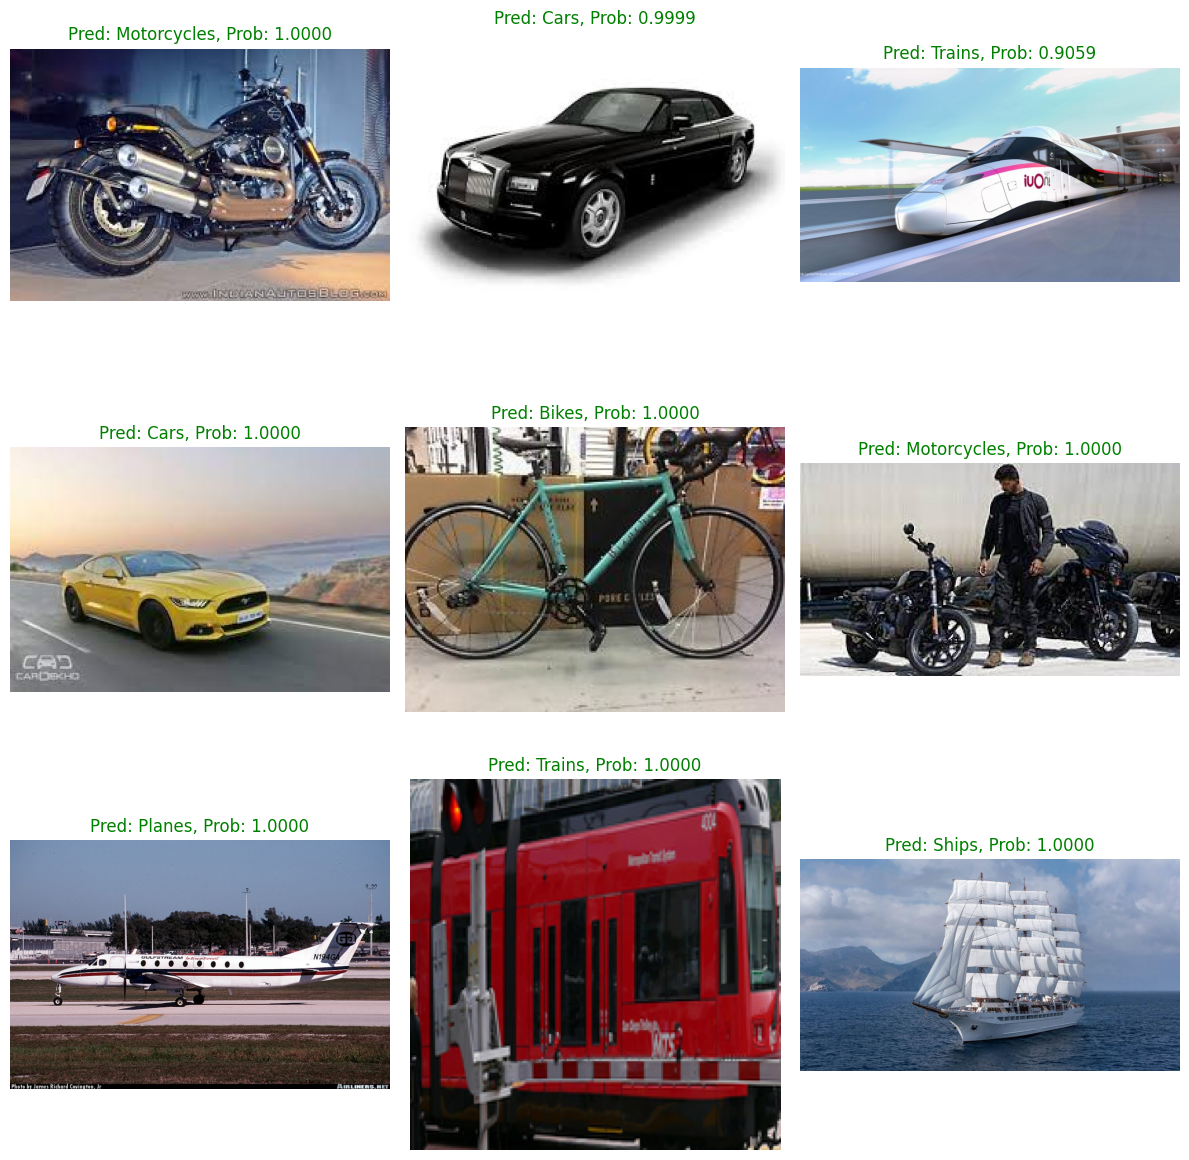

In [75]:
import matplotlib.pyplot as plt
import random
from fastai.vision.all import *
import numpy as np

# Select random test images
n_images = 9
test_images = get_image_files(os.path.join(base_split_dir, "test"))
random_images = random.sample(test_images, n_images)

# Create a 3x3 grid for displaying the images
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

# Iterate over the selected images and plot them
for i, img_path in enumerate(random_images):
    img = PILImage.create(img_path)  # Load the image
    pred, _, probs = learn.predict(img)  # Make prediction

    # Get the corresponding row and column for the subplot
    row, col = divmod(i, 3)

    # Plot the image
    axs[row, col].imshow(img)
    axs[row, col].axis('off')  # Hide axes

    # Set the title with prediction and probability
    axs[row, col].set_title(f'Pred: {pred}, Prob: {max(probs):.4f}', color='green' if max(probs) > 0.5 else 'red')

plt.tight_layout()
plt.show()


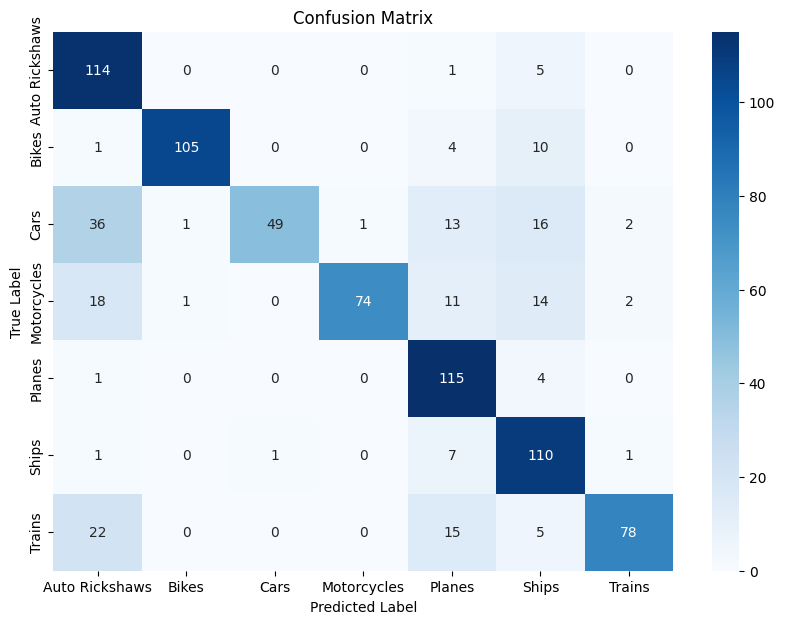

In [70]:
val_dl = dls.valid  # Using validation dataloader (which has labels)

# Generate predictions on the validation set
preds, targets = learn.get_preds(dl=val_dl)
predicted_classes = np.argmax(preds, axis=1)

# Convert the targets to numpy for compatibility with sklearn functions
true_classes = targets.numpy()

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dls.vocab, yticklabels=dls.vocab)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [71]:
# Classification report (precision, recall, f1-score)
report = classification_report(true_classes, predicted_classes, target_names=categories)
print("Classification Report:\n", report)

Classification Report:
                 precision    recall  f1-score   support

Auto Rickshaws       0.59      0.95      0.73       120
         Bikes       0.98      0.88      0.93       120
          Cars       0.98      0.42      0.58       118
   Motorcycles       0.99      0.62      0.76       120
        Planes       0.69      0.96      0.80       120
         Ships       0.67      0.92      0.77       120
        Trains       0.94      0.65      0.77       120

      accuracy                           0.77       838
     macro avg       0.83      0.77      0.76       838
  weighted avg       0.83      0.77      0.76       838



In [72]:
train_losses = learn.recorder.losses
valid_losses = [v[0] for v in learn.recorder.values]

print(f"Training losses: {train_losses}")
print(f"Validation losses: {valid_losses}")

# Print metrics (e.g., accuracy) if you tracked metrics during training
if 'accuracy' in learn.recorder.metric_names:
    accuracy_history = [v[1] for v in learn.recorder.values]
    print(f"Accuracy over epochs: {accuracy_history}")

Training losses: []
Validation losses: [0.6943780183792114]
Accuracy over epochs: [0.7696897387504578]


/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


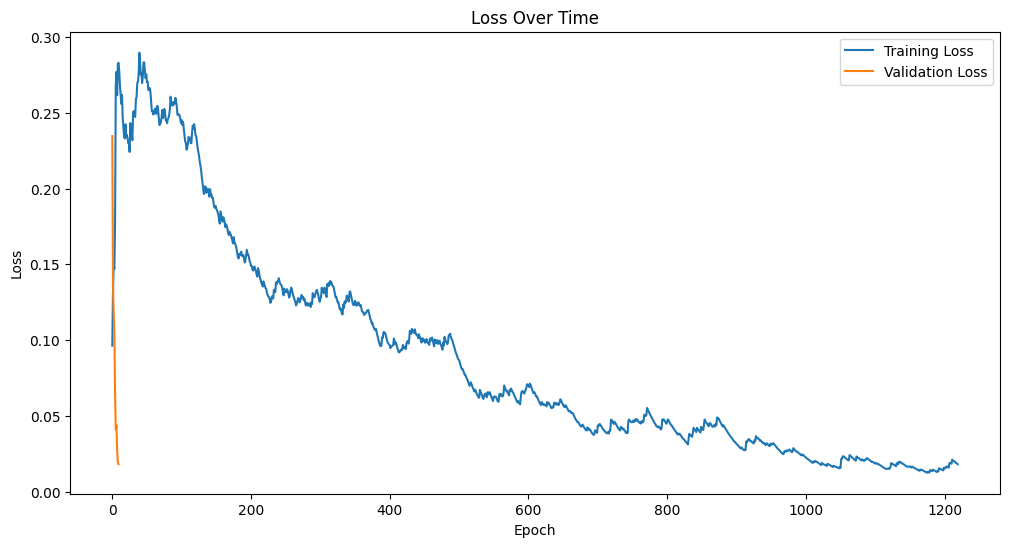

In [73]:
import pickle
import matplotlib.pyplot as plt

# Load the FastAI model history (for fastai_model_history.pkl)
history_path = '/content/drive/My Drive/models/fastai_model_history.pkl'
with open(history_path, 'rb') as file_pi:
    history = pickle.load(file_pi)

# Plot accuracy and loss over epochs
train_losses = [loss.item() for loss in history['train_loss']]
valid_losses = [loss[0] for loss in history['valid_loss']]

# Plot loss over epochs (FastAI)
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
import time

# Calculate the number of steps per epoch for the test data
test_dl = dls.test_dl(get_image_files(os.path.join(base_split_dir, "test")))
test_steps_per_epoch = len(test_dl)

# Start the timer
start_time = time.time()

# Make predictions on the test set
preds, targets = learn.get_preds(dl=test_dl)

# End the timer
end_time = time.time()

# Calculate total inference time
inference_time = end_time - start_time
print(f'Total inference time: {inference_time:.2f} seconds')

# Optionally, calculate the average inference time per batch/sample
avg_time_per_batch = inference_time / test_steps_per_epoch
avg_time_per_sample = inference_time / len(test_dl.items)

print(f'Average inference time per batch: {avg_time_per_batch:.4f} seconds')
print(f'Average inference time per sample: {avg_time_per_sample:.6f} seconds')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total inference time: 6.13 seconds
Average inference time per batch: 0.2270 seconds
Average inference time per sample: 0.007305 seconds


---------------------------